In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.7.tgz
!tar xf spark-2.4.8-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install jsonlines
!pip install plotly --upgrade

     |████████████████████████████████| 25.3 MB 61.6 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext(appName="YourTest", master="local[*]")
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
import jsonlines
from pyspark.sql.functions import explode,col
from pyspark.sql import functions as F
from pyspark.sql.functions import concat_ws
import pandas as pd

In [5]:
# Plot Libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [6]:
# Data Path
data_path ="/content/drive/My Drive/UWaterloo/Fall 21/CS 631/Project/sample.jsonl"
data = sqlContext.read.json(data_path).sort("year",ascending=False)
data.count()

50000

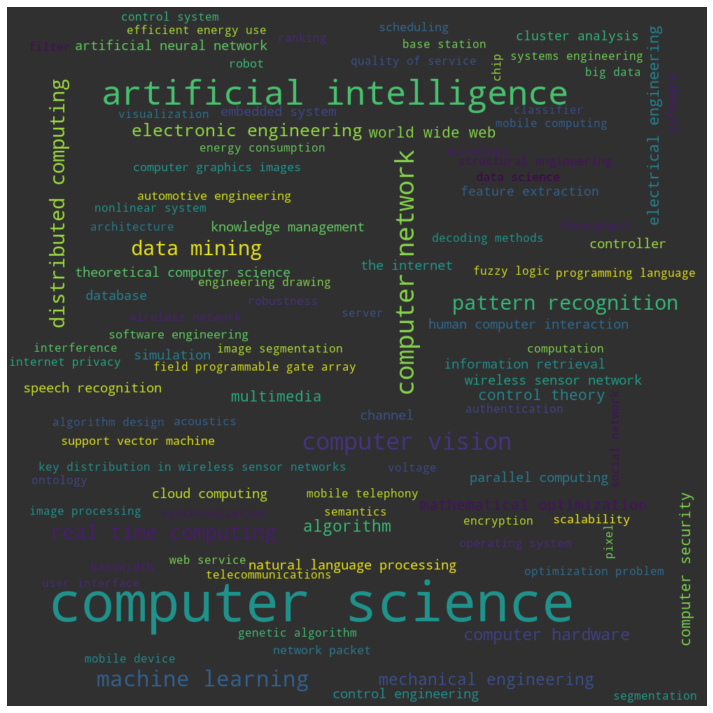

In [7]:
from wordcloud import WordCloud

def word_cloud_topics():
  topics = data.select("id",explode("topics").alias("topics"))\
                  .groupBy("topics").count()\
                  .sort("count",ascending=False).limit(100).toPandas()
  d = {}
  for a, x in topics.values:
      d[a] = x

  wordcloud = WordCloud(width = 1000, height = 1000,
                  background_color ="#303030",
                  min_font_size = 10)# stopwords = stopwords,
  wordcloud.generate_from_frequencies(frequencies=d)
  plt.figure(figsize = (10, 10), facecolor = None)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.tight_layout(pad = 0)
  plt.axis("off")
  plt.show()

word_cloud_topics()

In [8]:
# Main authors data
authors_data = data.select("id",explode("authors").alias("authors"))
authors_data = authors_data.select(authors_data.id.alias("paper_id"), \
    F.col("authors").getItem("name").alias("name"), \
    F.col("authors").getItem("country").alias("country"), \
    F.col("authors").getItem("id").alias("author_id"), \
    F.col("authors").getItem("affiliation").alias("affiliation"), \
    F.col("authors").getItem("affiliationid").alias("affiliationid"), \
    F.col("authors").getItem("order").alias("order"))

# Removing authors with less than 5 papers
authors_valid = authors_data.groupBy("author_id").agg(F.count("paper_id")).filter(col("count(paper_id)")>5)
authors_data = authors_data.join(authors_valid,on="author_id",how="leftsemi")


In [9]:
coauthors_data = authors_data.select("paper_id","author_id","name")\
            .join(data.select("id",explode("authors").alias("authors"),"topics"),authors_data.paper_id==data.id,"left")\
            .withColumn("n_topics",1/F.size("topics"))\
            .select("n_topics","name",explode("topics").alias("topics"),\
                    F.col("authors").getItem("name").alias("coauthor_name"))\
            .groupBy("name","coauthor_name","topics").agg(F.sum(col("n_topics")).alias("Number of Papers"))
coauthors_data.cache()

DataFrame[name: string, coauthor_name: string, topics: string, Number of Papers: double]

In [11]:
# Update plotly firtst
selected_author = "victor c m leung"
def coauthors_treemap(selected_author):
  colabs = coauthors_data.filter(col("name")==selected_author).filter(col("coauthor_name")!=selected_author)\
            .toPandas()
  fig = px.treemap(colabs, path=['name','coauthor_name','topics'],
                  values='Number of Papers') 
  fig.show()

coauthors_treemap(selected_author)